# Python toolkit for fluorescence data processing

Author: Yongmin Hu (yongmin.hu@eawag.ch)

Last update: 2022-07-05

Before running the toolkit, please go through checklist_fluorescence_python_toolkit.doc.

If you change the input in any of the code blocks, please re-run all blocks after.

# 0. Import packages

In [1]:
import matplotlib
import os
import numpy as np
import matplotlib.pyplot as plt
import re

from datetime import datetime, timedelta, date
from EEMprocessing import *
from generate_widgets import *
from ipywidgets import interact, interactive, interact_manual
from ipywidgets import Layout, Button, Dropdown, Label, FloatText, Text, IntSlider, Checkbox, Box
from IPython.display import display, clear_output
from traitlets import traitlets


matplotlib.rcParams['figure.dpi'] = 80


-------------------------------------------
# 1. Specify data directory and filename format

In [7]:
# read all filenames in the target directory
filedir_default = '_data/_greywater/20220111_RT' # Just the default, could be changed

Part1_widgets = Widgets1(filedir_default)
data_selection = Part1_widgets.generate_widgets()
display(data_selection)


Box(children=(VBox(children=(Label(value='Pleae specify the directory of fluorescence data in the text box bel…

-----------------------------------------
# 2. Data preview and parameter selection

In [8]:
# Visualization with interaction
datdir = Part1_widgets.dir_selection.value
filelist = os.listdir(datdir)
datlist = [file for file in filelist if 'PEM.dat' in file]
data_index = []
if Part1_widgets.ts_read_from_filename.value:
    tslist = [get_TS_from_filename(file, ts_format=Part1_widgets.ts_format.value, 
                                   ts_start_position=Part1_widgets.ts_start_position.value-1,
                                   ts_end_position=Part1_widgets.ts_end_position.value) for file in datlist]
    tslist_sortidx = np.argsort(tslist)
    tslist_sorted = [tslist[i] for i in tslist_sortidx]
    datlist = [datlist[i] for i in tslist_sortidx]
else:
    data_index = [file[:-4] for file in datlist]
    
# --------------Create widgets for plotting parameters-------------

intensity_range = (0,18000,100) # (min, max, step）
em_range = (260,500,10)
ex_range = (250,400,10)

ts_format = Part1_widgets.ts_format.value
ts_start_position = Part1_widgets.ts_start_position.value
ts_end_position = Part1_widgets.ts_end_position.value

Part2and3_widgets = Widgets2and3(intensity_range, em_range, ex_range, datdir, datlist, ts_format, ts_start_position,
                 ts_end_position)
tab2, note_step2, out_parameters = Part2and3_widgets.generate_widgets()

display(tab2, note_step2, out_parameters)


Output()

----------------------------------------------------
# 3. Stack data

For further analysis, the parameters would be set according to the settings in the above interface!

PLEASE CHECK THE SETTINGS before going-on!


In [9]:
#-------------------------Stack data------------------------------
stacking_interact = Part2and3_widgets.generate_widgets2()
caption = ipywidgets.Label(value='The stack includes all fluorescence data whose filename contains the specified keyword.')
display(caption, stacking_interact)

Label(value='The stack includes all fluorescence data whose filename contains the specified keyword.')

interactive(children=(Text(value='PEM.dat', description='Filename searching keyword: ', style=DescriptionStyle…

------------------------------------------
# 4. Remove unwanted data from the data stack

Please run the code block even if you don't want to do any operation here.

Label(value='This block is used to remove specific data from the data stack. Please select the data you want t…

Label(value="To reset the data stack to its original state: re-run the block. If you don't want to make any ch…

overview of artefacts detected


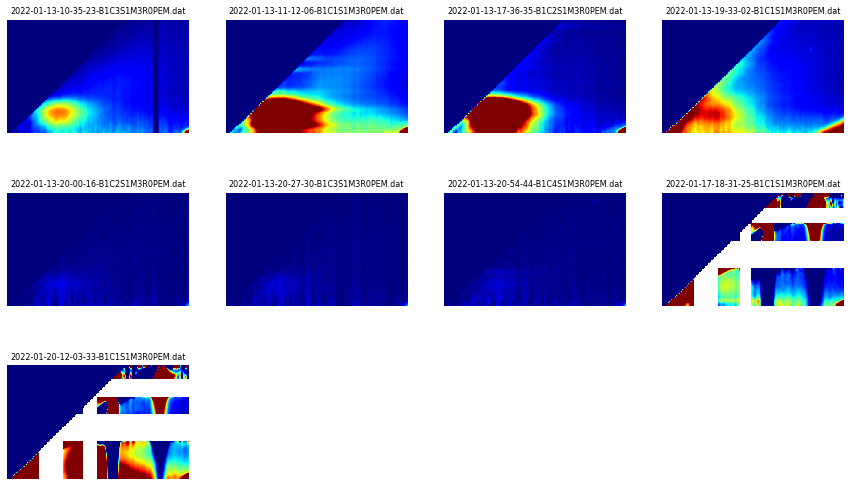

"2022-01-13-10-35-23-B1C3S1M3R0PEM.dat" has been removed
"2022-01-13-11-12-06-B1C1S1M3R0PEM.dat" has been removed
"2022-01-13-17-36-35-B1C2S1M3R0PEM.dat" has been removed
"2022-01-13-19-33-02-B1C1S1M3R0PEM.dat" has been removed
"2022-01-13-20-00-16-B1C2S1M3R0PEM.dat" has been removed
"2022-01-13-20-27-30-B1C3S1M3R0PEM.dat" has been removed
"2022-01-13-20-54-44-B1C4S1M3R0PEM.dat" has been removed
"2022-01-17-18-31-25-B1C1S1M3R0PEM.dat" has been removed
"2022-01-20-12-03-33-B1C1S1M3R0PEM.dat" has been removed


In [11]:
#------------------Remove specific data from the data stack-----------------

eem_stack_all, em_range_cw, ex_range_cw, datlist_all, abs_stack, ex_range_abs = stacking_interact.result

Part4_widgets = Widgets4(eem_stack_all, datlist_all, em_range_cw, ex_range_cw, Part2and3_widgets.preview_parameter_dict)

manual_cleaning = Part4_widgets.generate_widgets_1()

# auto cleaning
auto_cleaning = Part4_widgets.generate_widgets_2()


tab4 = ipywidgets.Tab()
tab4.children = [manual_cleaning, auto_cleaning]
tab4.set_title(0, 'Manual cleaning')
tab4.set_title(1, 'Auto cleaning')


caption = ipywidgets.Label(
    'This block is used to remove specific data from the data stack. Please select the data you want to remove:')
caption2 = ipywidgets.Label(
    "To reset the data stack to its original state: re-run the block. If you don't want to make any changes here,"
    " please skip.")

display(caption, tab4, caption2)


-------------------------------------
# 5. Data stack analysis

In [12]:
%matplotlib inline
#--------------------Data stack analysis---------------
pd.set_option('display.max_rows', None)
datlist_filtered = Part4_widgets.datlist_filtered
idx2remove = Part4_widgets.idx2remove

# Are there any changes in the last step?
data_index_cw = []

if datlist_filtered==datlist_all:
    datlist_cw = datlist_all[:]
    eem_stack_cw = eem_stack_all[:,:,:]
else:
    datlist_cw = datlist_filtered[:]
    eem_stack_cw = np.delete(eem_stack_all, idx2remove, 0)
    
if Part1_widgets.ts_read_from_filename.value:
    timestamps_cw = [get_TS_from_filename(dat, Part1_widgets.ts_format.value, 
                                          Part1_widgets.ts_start_position.value-1, 
                                          Part1_widgets.ts_end_position.value)
                for dat in datlist_cw ]
    timestamps_cw_sortidx = np.argsort(timestamps_cw)
    timestamps_cw = [timestamps_cw[i] for i in timestamps_cw_sortidx]
    datlist_cw = [datlist_cw[i] for i in timestamps_cw_sortidx]
    eem_stack_cw = eem_stack_cw[timestamps_cw_sortidx]
else:
    data_index_cw = [file[:-4] for file in datlist_cw]
    timestamps_cw = False

#---------------Create widgets------------------------
#----------------General widgets------------
out = ipywidgets.Output()
display(out)

button_clear_display=ipywidgets.Button(description='Clear display')
def clear_display_with_button(b):
    clear_output()
    display(tab)
button_clear_display.on_click(clear_display_with_button)

#-------Tab1: File range selection----------

Part51_widgets = Widgets51(datlist_cw)
data_range_items, range1, range2 = Part51_widgets.generate_widgets()

data_range = Box(data_range_items,
                 layout=Layout(display='flex', flex_flow='column', border='none', align_items='stretch', width='80%'))


#-------Tab2: Pixel statistics------------------

Part52_widgets = Widgets52(eem_stack_cw, datlist_cw, range1, range2, em_range_cw, ex_range_cw, timestamps_cw)
pixel_statistics_items = Part52_widgets.generate_widgets()

pixel_statistics_items.append(ipywidgets.Box([button_clear_display]))
pixel_statistics = Box(pixel_statistics_items, 
                       layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='100%'))

#-------Tab3: EEM statistics---------

Part53_widgets = Widgets53(eem_stack_cw, datlist_cw, range1, range2, em_range_cw, ex_range_cw, timestamps_cw, 
                           Part2and3_widgets.crange_cw)
eem_statistics_items = Part53_widgets.generate_widgets()

eem_statistics_items.append(ipywidgets.Box([button_clear_display]))

eem_statistics = Box(eem_statistics_items, 
                     layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='100%'))

#-------Tab4: Region integration------------

Part54_widgets = Widgets54(eem_stack_cw, datlist_cw, range1, range2, em_range_cw, ex_range_cw, timestamps_cw)

integration_items = Part54_widgets.generate_widgets()
integration_items.append(ipywidgets.Box([button_clear_display]))
region_integration = Box(integration_items, 
                         layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='60%'))


#-------Tab5: PARAFAC----------

parameter_selection = ipywidgets.Label(value='Parameter selection')

Part55_widgets = Widgets55(data_index, data_index_cw, timestamps_cw, eem_stack_cw, datlist_cw, range1, 
                         range2, em_range_cw, ex_range_cw)
decomposition_items = Part55_widgets.generate_widgets()
decomposition = Box(decomposition_items, 
                    layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='100%'))

Part56_widgets = Widgets56(Part55_widgets.decomposition_method_list, Part55_widgets.rank_display, Part2and3_widgets.crange_cw, 
                           data_index, data_index_cw, timestamps_cw, eem_stack_cw, datlist_cw, range1, 
                           range2, em_range_cw, ex_range_cw, Part55_widgets.dataset_normalization)

decomposition_reconstruction_items = Part56_widgets.generate_widgets()
decomposition_reconstruction_items.append(ipywidgets.Box([button_clear_display]))
decomposition_reconstruction = Box(decomposition_reconstruction_items, 
                                   layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='80%'))

Part57_widgets = Widgets57(eem_stack_cw, em_range_cw, ex_range_cw, Part55_widgets.rank_display,
                           Part55_widgets.decomposition_method_list, datlist_cw, range1, range2,
                           Part55_widgets.dataset_normalization)
split_validation_items = Part57_widgets.generate_widgets()
split_validation_items.append(ipywidgets.Box([button_clear_display]))
split_validation = Box(split_validation_items, 
                   layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='80%'))


tab_parafac = ipywidgets.Tab()
tab_parafac.children = [parameter_selection, decomposition, decomposition_reconstruction, split_validation]
tab_parafac.set_title(0, 'Parameter selection')
tab_parafac.set_title(1, 'Decomposition')
tab_parafac.set_title(2, 'Reconstruction error')
tab_parafac.set_title(3, 'Split validation')


# -----------------Assembly tabs-------------------

tab = ipywidgets.Tab() 
tab.children=[data_range, pixel_statistics, eem_statistics, region_integration, tab_parafac]

tab.set_title(0, '1. Data range selection')
tab.set_title(1, '2. Pixel statistics')
tab.set_title(2, '3. EEM statistics')
tab.set_title(3, '4. Region integraion')
tab.set_title(4, '5. PARAFAC')
tab.set_title(5, '6. PARAFAC reconstruction')
display(tab)

Output()

# 6. Save PARAFAC result

In [204]:
score_df, ex_df, em_df = Part55_widgets.button_decomposition_interact.result
Part6_widgets = Widgets6(score_df, ex_df, em_df, Part1_widgets.dir_selection.value, Part2and3_widgets.inner_filter_effect, 
                         Part2and3_widgets.scattering_correction, Part2and3_widgets.gaussian_smoothing, 
                         Part55_widgets.decomposition_method_list, Part55_widgets.dataset_normalization)
output_items = Part6_widgets.generate_widgets()
decomposition_output = Box(output_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='none',
    align_items='stretch',
    width='80%'
))
display(decomposition_output)

Box(children=(Box(children=(Label(value='Mandatory fields are marked with *'),)), Box(children=(Text(value='_d…

# Test

In [16]:
eem_stack_removed = eem_stack_grab - eem_stack_filtered

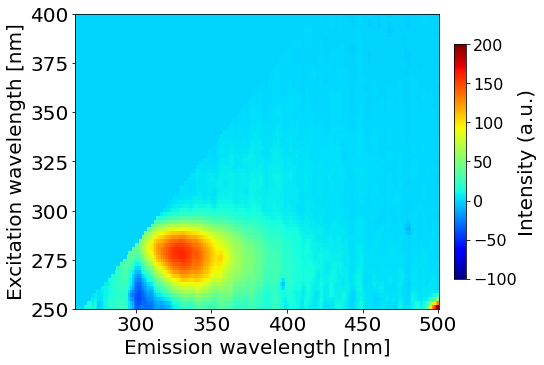

In [38]:
EEMs = EEMstack(eem_stack_removed, em_range_cw, ex_range_cw)
plot3DEEM(EEMs.mean(), em_range_cw, ex_range_cw, cmin=-100, cmax=200, aspect=1.3)

In [41]:
rf = pd.DataFrame(EEMs.mean(), columns=em_range_cw, index=np.flip(ex_range_cw))
rf.to_csv('../openFluor/openFluor/removed_fluorescence.csv', sep='\t')


B1S12022-01-28-10-46-filtered-M3PEM.dat
B1S12022-01-28-11-16-filtered-M3PEM.dat
B1S12022-01-28-12-16-filtered-M3PEM.dat
B1S12022-01-28-13-16-filtered-M3PEM.dat
B1S12022-01-28-16-16-filtered-M3PEM.dat


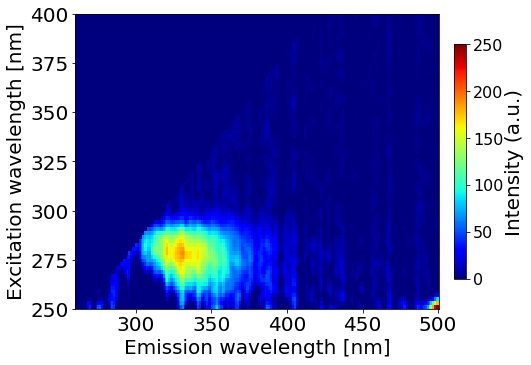

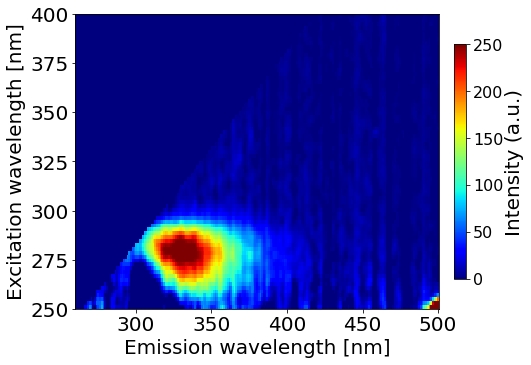

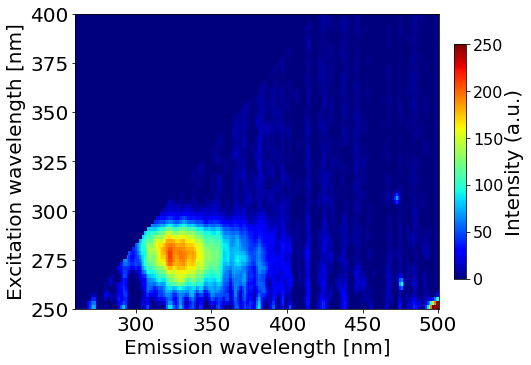

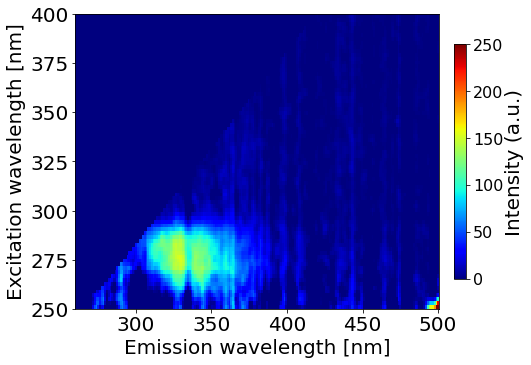

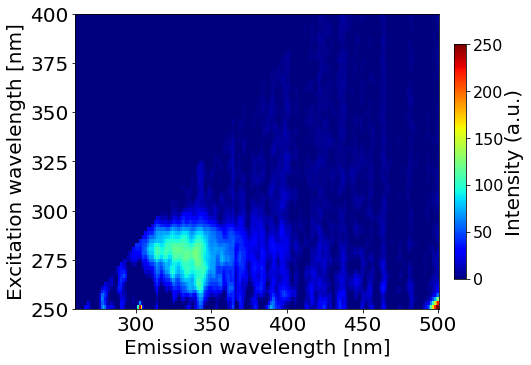

In [18]:
for i in range(32, 37):
    print(datlist_cw[i])
    plot3DEEM(eem_stack_removed[i], em_range_cw, ex_range_cw, cmin=0, cmax=250, aspect=1.3)

0.37055979297346014
0.42495536962918934
0.3981455150533233


<Figure size 1080x360 with 0 Axes>

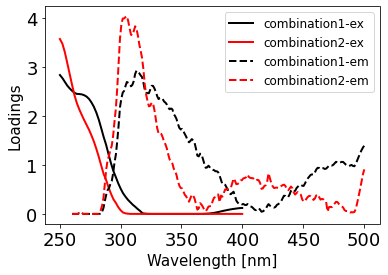

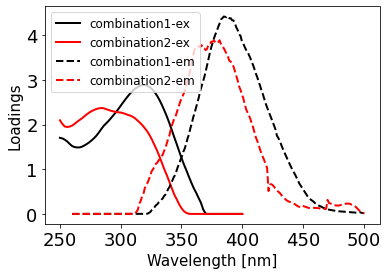

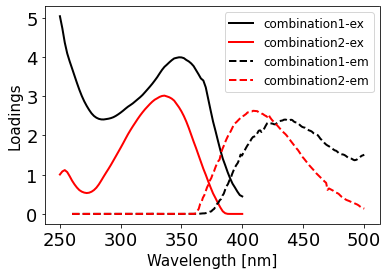

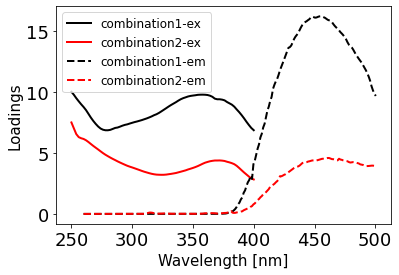

In [11]:
def test(eem_stack, em_range, ex_range, rank, n_split=4, combination_size='half', n_test='max',
                               rule='random', index=[], criteria='TCC', plot_worst_test=True):
    split_set = eem_stack_spliting(eem_stack, n_split=n_split, rule=rule)
    if combination_size == 'half':
        cs = int(n_split)/2
    elif not isinstance(combination_size, str):
        cs = combination_size
    combos = []
    for i in itertools.combinations([i for i in range(n_split)], int(cs*2)):
        elements = list(itertools.combinations(i, int(cs)))
        for j in range(int(len(elements)/2)):
            combos.append([elements[j], elements[-1-j]])
    if n_test == 'max':
        n_t = int(len(combos))
    elif n_test > int(len(combos)):
        n_t = int(len(combos))
    idx = random.sample(range(len(combos)), n_t)
    test_count = 0
    sim = []
    
    while test_count < n_t:
        c1 = combos[idx[test_count]][0]
        c2 = combos[idx[test_count]][1]
        eem_stack_c1 = np.concatenate([split_set[i] for i in c1], axis=0)
        eem_stack_c2 = np.concatenate([split_set[i] for i in c2], axis=0)
        
        score1_df, J1_df, K1_df, _, _, _ = decomposition_interact(
            eem_stack_c1, em_range, ex_range, rank, index=index, decomposition_method='non_negative_parafac', dataset_normalization=True,
            score_normalization=False, loadings_normalization=True, component_normalization=False, plot_loadings=False, 
            plot_components=False, display_score=False, component_autoscale=True, sort_em=True)
        
        score2_df, J2_df, K2_df, _, _, _ = decomposition_interact(
            eem_stack_c2, em_range, ex_range, rank, index=index, decomposition_method='non_negative_parafac', dataset_normalization=True,
            score_normalization=False, loadings_normalization=True, component_normalization=False, plot_loadings=False, 
            plot_components=False, display_score=False, component_autoscale=True, sort_em=True)
        
        m_sim, matched_index, max_sim = match_parafac_components(J1_df, K1_df, J2_df, K2_df, criteria=criteria,
                                                 wavelength_synchronization=True, mode='mean')
        sim.append(sum(max_sim)/len(max_sim))
        print(sum(max_sim)/len(max_sim))
        test_count += 1
        
    if plot_worst_test:
        worst_test_idx = sim.index(min(sim))
        c1 = combos[idx[worst_test_idx]][0]
        c2 = combos[idx[worst_test_idx]][1]
        eem_stack_c1 = np.concatenate([split_set[i] for i in c1], axis=0)
        eem_stack_c2 = np.concatenate([split_set[i] for i in c2], axis=0)
        
        score1_df, J1_df, K1_df, _, _, _ = decomposition_interact(
            eem_stack_c1, em_range, ex_range, rank, index=index, decomposition_method='non_negative_parafac', dataset_normalization=False,
            score_normalization=False, loadings_normalization=True, component_normalization=False, plot_loadings=False, 
            plot_components=False, display_score=False, component_autoscale=True, sort_em=True)
        
        score2_df, J2_df, K2_df, _, _, _ = decomposition_interact(
            eem_stack_c2, em_range, ex_range, rank, index=index,decomposition_method='non_negative_parafac', dataset_normalization=False,
            score_normalization=False, loadings_normalization=True, component_normalization=False, plot_loadings=False, 
            plot_components=False, display_score=False, component_autoscale=True, sort_em=True)
        _, matched_index, _ = match_parafac_components(J1_df, K1_df, J2_df, K2_df, criteria=criteria,
                                                 wavelength_synchronization=True, mode='mean')
        
        for c in matched_index:
            plt.figure()
            plt.plot(J1_df.index.get_level_values(1), J1_df.iloc[:, c[0]], color='black', linewidth=2, label='combination1-ex')
            plt.plot(J2_df.index.get_level_values(1), J2_df.iloc[:, c[1]], color='red', linewidth=2, label='combination2-ex')
            plt.plot(K1_df.index.get_level_values(1), K1_df.iloc[:, c[0]], color='black', linewidth=2, linestyle='dashed',
                     label='combination1-em')
            plt.plot(K2_df.index.get_level_values(1), K2_df.iloc[:, c[1]], color='red', linewidth=2, linestyle='dashed',
                     label='combination2-em')
            plt.legend(fontsize=12)
            plt.xlabel('Wavelength [nm]', fontsize=15)
            plt.ylabel('Loadings', fontsize=15)
    return sim, m_sim

sim, m_sim = test(eem_stack_cw, em_range_cw, ex_range_cw, rank=4, n_split=4, combination_size='half', n_test='max',
                               rule='random', index=[], criteria='TCC', plot_worst_test=True)